In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import umap
import seaborn as sns
from utils import *
from metrics import *

def load_visualization_data(fold_num, data_path):
    viz_file_path = os.path.join(data_path, f'visualization_data_fold_{fold_num}.pt')
    if not os.path.exists(viz_file_path):
        print(f"Error: Visualization data file not found at {viz_file_path}")
        return None
    print(f"Loading data from {viz_file_path}...")
    return torch.load(viz_file_path)

def plot_comparison_for_fold(fold_num, data_path='results/My/'):
    print(f"--- Generating comparison plot for Fold {fold_num} ---")
    
    viz_data = load_visualization_data(fold_num, data_path)
    if not viz_data:
        return

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle(f'Embedding Comparison for Fold {fold_num}', fontsize=16)

    initial_emb_dict = {k: torch.from_numpy(v) for k, v in viz_data['initial_embeddings'].items()}
    original_pos_emb, original_neg_emb = obtain_embbedings(initial_emb_dict, viz_data['val_pos_edges'], viz_data['val_neg_edges'])
    visualize_embeddings_with_umap(
        original_pos_emb, 
        original_neg_emb, 
        ax=axes[0], 
        title='Initial Embeddings'
    )

    learned_embeddings = viz_data['learned_embeddings']
    if learned_embeddings:
        learned_emb_dict = {k: torch.from_numpy(v) for k, v in learned_embeddings.items()}
        best_pos_emb, best_neg_emb = obtain_embbedings(learned_emb_dict, viz_data['val_pos_edges'], viz_data['val_neg_edges'])
        visualize_embeddings_with_umap(
            best_pos_emb, 
            best_neg_emb, 
            ax=axes[1],
            title='Learned Embeddings (Best Epoch)'
        )
    else:
        axes[1].text(0.5, 0.5, 'No learned embeddings found.', ha='center', va='center')
        axes[1].set_title('Learned Embeddings (Best Epoch)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_all_folds(data_path='results/My/'):
    print("--- Generating global plot for all 5 folds ---")

    fig, axes = plt.subplots(5, 2, figsize=(18, 40))
    fig.suptitle('Embeddings Overview Across All Folds', fontsize=20)

    for i in range(5):
        fold_num = i + 1
        ax_initial = axes[i, 0]
        ax_learned = axes[i, 1]

        viz_data = load_visualization_data(fold_num, data_path)
        if not viz_data:
            ax_initial.text(0.5, 0.5, f'Data for Fold {fold_num}\nnot found.', ha='center', va='center')
            ax_learned.text(0.5, 0.5, f'Data for Fold {fold_num}\nnot found.', ha='center', va='center')
            ax_initial.set_title(f'Initial - Fold {fold_num}')
            ax_learned.set_title(f'Learned - Fold {fold_num}')
            continue

        initial_emb_dict = {k: torch.from_numpy(v) for k, v in viz_data['initial_embeddings'].items()}
        original_pos_emb, original_neg_emb = obtain_embbedings(initial_emb_dict, viz_data['val_pos_edges'], viz_data['val_neg_edges'])
        visualize_embeddings_with_umap(original_pos_emb, original_neg_emb, ax=ax_initial, title=f'Initial - Fold {fold_num}')

        learned_embeddings = viz_data['learned_embeddings']
        if learned_embeddings:
            learned_emb_dict = {k: torch.from_numpy(v) for k, v in learned_embeddings.items()}
            best_pos_emb, best_neg_emb = obtain_embbedings(learned_emb_dict, viz_data['val_pos_edges'], viz_data['val_neg_edges'])
            visualize_embeddings_with_umap(best_pos_emb, best_neg_emb, ax=ax_learned, title=f'Learned (Best) - Fold {fold_num}')
        else:
            ax_learned.text(0.5, 0.5, 'No learned embeddings found.', ha='center', va='center')
            ax_learned.set_title(f'Learned (Best) - Fold {fold_num}')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig("figure/fold embedding.png", dpi=300)
    plt.show()

c:\Users\wsy\.conda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Generating comparison plot for Fold 2 ---
Loading data from results/My/visualization_data_fold_2.pt...


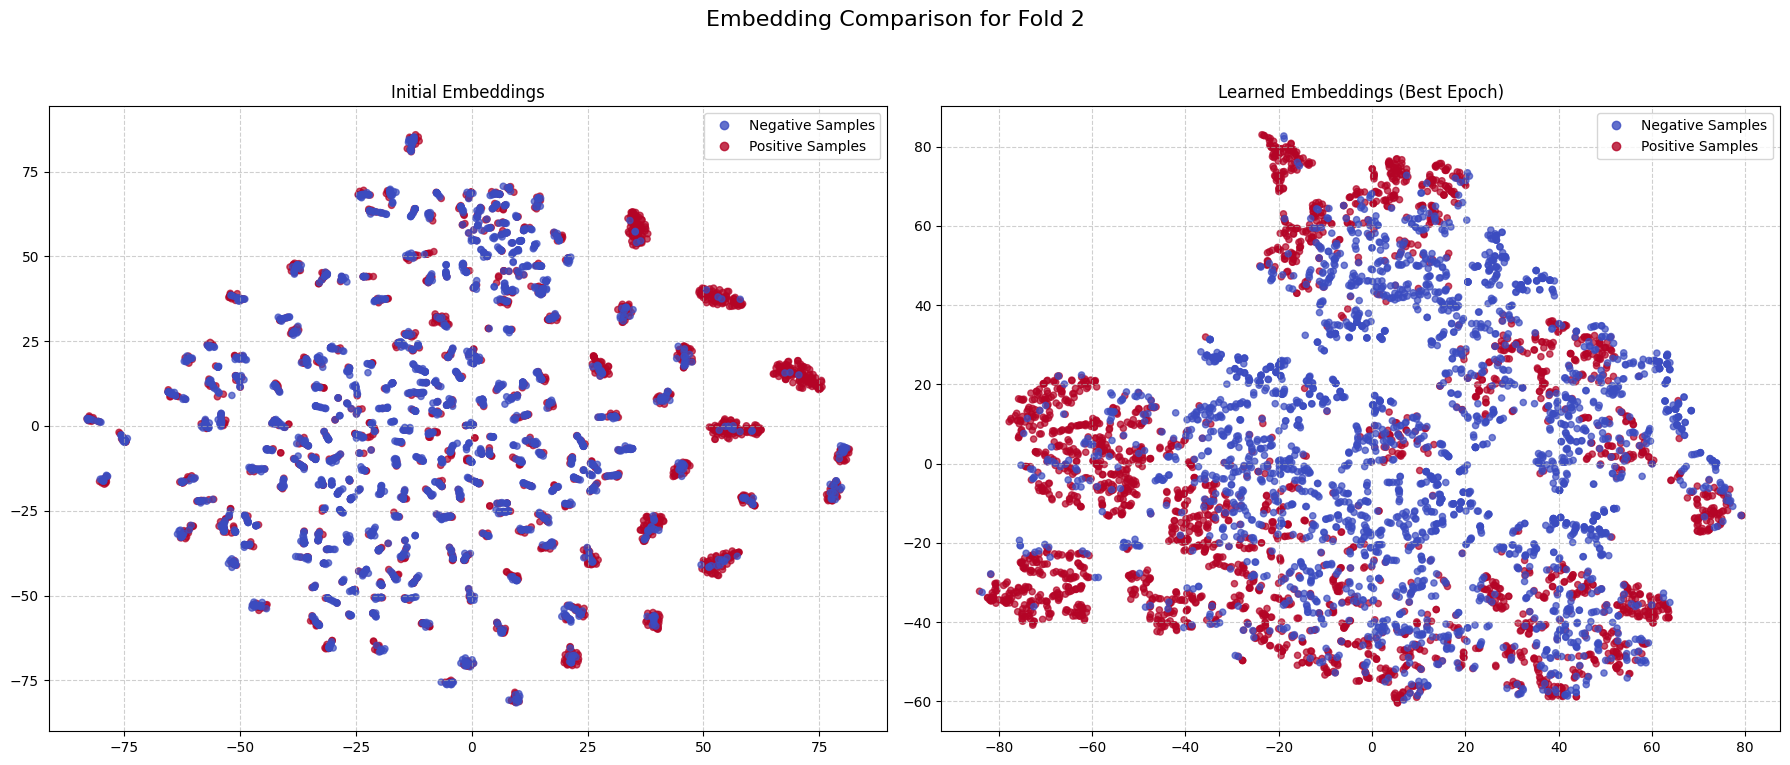

In [4]:
plot_comparison_for_fold(3)
# plot_all_folds() # code for plot the associations embeddings

In [ ]:
# code for generate GMT file to analyse gene ontology
import re
from collections import defaultdict

annotation_file_path = 'Dataset/uniprotkb_Homo_sapiens_AND_reviewed_tru_2025_06_23.xlsx'
go_col = 'Gene Ontology (biological process)' # can be replaced by: Gene Ontology (biological process) Gene Ontology (cellular component) Gene Ontology (molecular function) Gene Ontology (GO)

try:
    df = pd.read_excel(annotation_file_path)
except FileNotFoundError:
    print(f"error:can't find the target file'{annotation_file_path}'.")
    exit()

go_to_genes = defaultdict(list)
for index, row in df.iterrows():
    gene_name_str = row.get('Gene Names')
    if pd.isna(gene_name_str):
        continue
    primary_gene_name = gene_name_str.split(' ')[0]

    go_terms_str = row.get(go_col)
    if pd.isna(go_terms_str):
        continue

    go_terms = go_terms_str.split(';')
    for term in go_terms:
        term = term.strip()
        if term:
            match = re.match(r'(.+)\s[\[\(]GO:(\d+)[\]\)]', term)
            if match:
                go_full_name = f"{match.group(1).strip()} ({match.group(2)})"
                go_to_genes[go_full_name].append(primary_gene_name)

print(f"process successfully, find {len(go_to_genes)} single GO biological process.")



处理完成，共找到 12118 个独立的GO生物学过程。


In [ ]:
res_path = 'results/My/'
output_gmt_path = res_path + 'go_bp.gmt'

with open(output_gmt_path, 'w') as f:
    for go_term, genes in go_to_genes.items():
        gene_str = '\t'.join(sorted(list(set(genes))))
        f.write(f"{go_term}\tna\t{gene_str}\n")

print(f"GMT file has been created in: {output_gmt_path}")

background_genes = pd.unique(df['Gene Names'].dropna().apply(lambda x: x.split(' ')[0]))
print(f"Background Gene Set includes {len(background_genes)} genes.")

GMT文件已成功创建在: results/My/go_bp.gmt
背景基因集共包含 21110 个基因。


In [ ]:
# get the predictions
prediction_list = []
for i in range(5):
    predictions = np.load(res_path + 'train_fold_' + str(i+1) + '_predition.npy')
    prediction_list.append(predictions)
conbined_pred = np.vstack(prediction_list)
pred_map = defaultdict(list)
for row in conbined_pred:
    key = (int(row[0]), int(row[1]))
    score = row[2]
    pred_map[key].append(score)

average_pred_list = []
for key, scores in pred_map.items():
    average_score = sum(scores) / len(scores)
    average_pred_list.append([key[0], key[1], average_score])

# get the disease map
train_map_filepath = "Dataset/Data/trainnode_index_map.xlsx"
train_node_dict = pd.read_excel(train_map_filepath)
train_disease_map = train_node_dict['disease'].dropna().astype(int)

# find the target disease and it's top 10 gene
target_disease_index = 100
disease_name = pd.read_csv('Raw_Data/disease_name.csv').iloc[:, 1].tolist()
target_disease = disease_name[train_disease_map.iloc[target_disease_index]]
print("target disease:", target_disease)
train_gene_map = train_node_dict['gene'].dropna().astype(int)
pcg_genes = pd.read_csv('Raw_Data/pcg_gene.csv').iloc[:, 1].tolist()
disease_target_genes = [pair for pair in average_pred_list if pair[0] == target_disease_index]
sorted_disease_target_genes = sorted(disease_target_genes, key=lambda x: x[2], reverse=True)
print(sorted_disease_target_genes)
top_10_gene_index = [pair[1] for pair in sorted_disease_target_genes[:10]]
top_10_gene = [pcg_genes[train_gene_map.iloc[index]] for index in top_10_gene_index]
print(top_10_gene)

target disease: pulmonary embolism
[[100, 5144, 0.8579512685537338], [100, 1035, 0.8508328050374985], [100, 5882, 0.7804136425256729], [100, 4170, 0.7608266621828079], [100, 4253, 0.7501218616962433], [100, 1621, 0.7499339729547501], [100, 3551, 0.7428936660289764], [100, 3635, 0.7211716622114182], [100, 2703, 0.7171576395630836], [100, 2567, 0.6994038671255112], [100, 4036, 0.6637436524033546], [100, 5964, 0.6468180269002914], [100, 3738, 0.624075323343277], [100, 2663, 0.6079992800951004], [100, 5727, 0.5191804692149162], [100, 378, 0.5125524774193764], [100, 3061, 0.47142770141363144], [100, 1354, 0.4485892429947853], [100, 4443, 0.4068668782711029], [100, 4614, 0.3719554618000984], [100, 139, 0.36339501664042473], [100, 5501, 0.33153659477829933], [100, 5434, 0.2950884625315666], [100, 823, 0.19240392744541168]]
['PLG', 'VWF', 'F2', 'SERPINF2', 'SERPINC1', 'SERPINE1', 'ALB', 'PLAT', 'MTHFR', 'PF4']


In [ ]:
# gene ontology analyse
import gseapy as gp

gene_list = ['F2', 'VWF', 'ALB', 'CD1A', 'THBD', 'MTHFR', 'SERPINC1', 'SERPINF2', 'PF4', 'SERPINE1']
gmt_file = res_path + 'go_bp.gmt'

gene_ontology_output_file = res_path + 'PE_Enrichment_Analysis_Results'

print(f"\nstart using gseapy ...")
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gmt_file,
                 background=background_genes,
                 outdir=gene_ontology_output_file,
                 cutoff=0.5 
                )
print(type(enr.res2d))
print("\n(Sorted by Adjusted P-value ):")
results_df = enr.results.sort_values(by='Adjusted P-value', ascending=True)
print(results_df[['Term', 'Overlap', 'Adjusted P-value', 'Odds Ratio', 'Genes']].head(15))


开始使用gseapy进行富集分析...
<class 'pandas.core.frame.DataFrame'>

结果预览 (按 Adjusted P-value 排序):
                                                  Term Overlap  \
47       negative regulation of fibrinolysis (0051918)    4/12   
40   negative regulation of blood coagulation (0030...    4/14   
24                              fibrinolysis (0042730)    3/19   
8                          blood coagulation (0007596)    4/93   
70        positive regulation of coagulation (0050820)     2/6   
60                       platelet activation (0030168)    3/62   
50   negative regulation of plasminogen activation ...     2/8   
51   negative regulation of platelet activation (00...     2/8   
95           regulation of blood coagulation (0030193)     2/9   
65   positive regulation of blood coagulation (0030...    2/16   
71   positive regulation of collagen biosynthetic p...    2/24   
52        negative regulation of proteolysis (0045861)    2/25   
1                       acute-phase response (000695

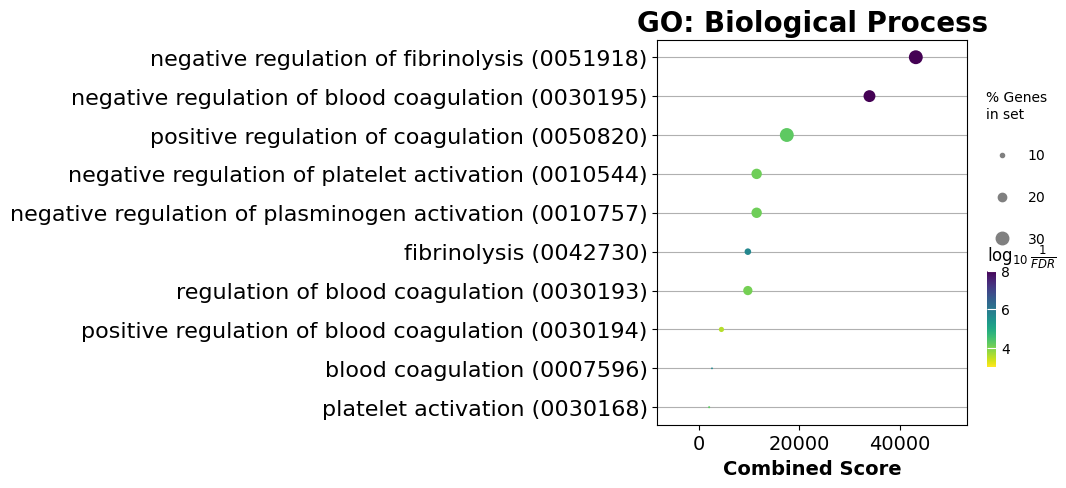

In [38]:
# bubble plot
from gseapy.plot import dotplot

# enr.results['Counts'] = enr.results['Genes'].apply(lambda x: len(x.split(';')))
ax = dotplot(enr.res2d,
             title='GO: Biological Process',
             top_term=10,
             size=5,
             figsize=(5,5)
             )
plt.show()

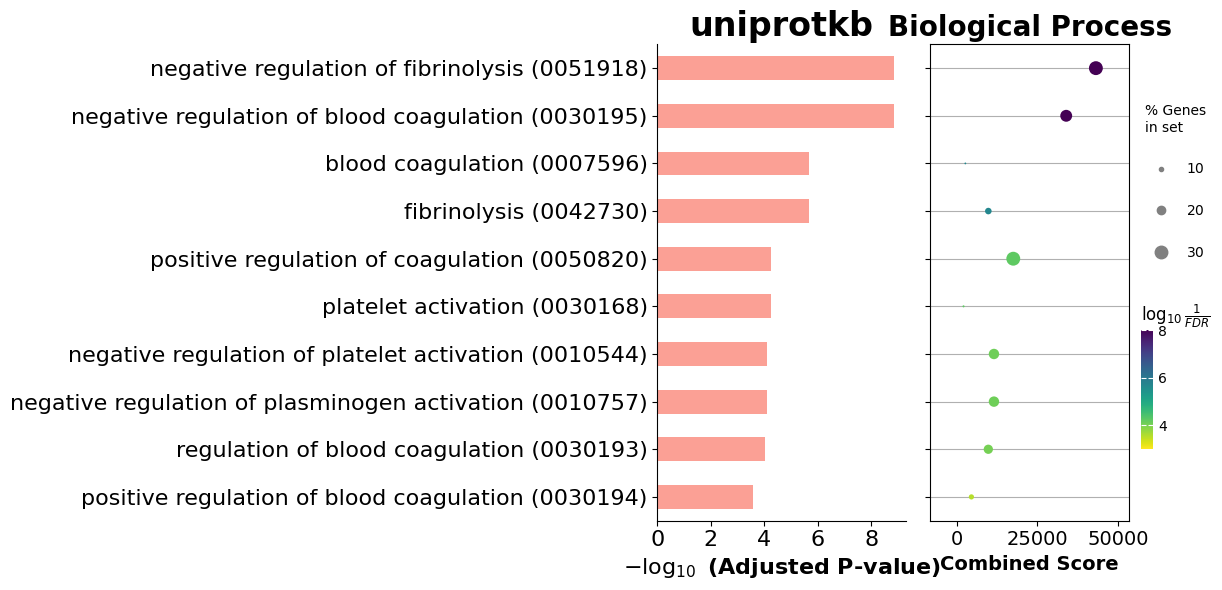

In [ ]:
from gseapy.plot import DotPlot

fig, (ax_bar, ax_dot) = plt.subplots(
    1, 2,
    figsize=(12, 6),
    sharey=True 
)

dot_bar = DotPlot(
    df=enr.res2d,
    y="Term",
    hue="Adjusted P-value",
    title="uniprotkb",
    thresh=0.05,
    n_terms=10,
    ax=ax_bar,
    figsize=(4, 6)
)

ax_bar = dot_bar.barh(color=["salmon"])
term_order = dot_bar.data["Term"].tolist()

dotplot(
    df=enr.res2d,
    column="Adjusted P-value",
    x="Combined Score",
    y="Term",
    y_order=term_order,
    title="Biological Process",
    cutoff=0.05,
    top_term=10,
    size=5,
    ax=ax_dot,
    cmap="viridis_r",
    show_ring=False
)

fig.tight_layout()
plt.subplots_adjust(wspace=0.1)

plt.savefig("figure/combined_enrichment_plot.png", bbox_inches="tight", dpi=300)
plt.show()

C:\Users\wsy\AppData\Local\Temp\ipykernel_10400\2322186857.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Value', data=metric_data, ax=ax, palette=colors)
C:\Users\wsy\AppData\Local\Temp\ipykernel_10400\2322186857.py:110: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.boxplot(x='Model', y='Value', data=metric_data, ax=ax, palette=colors)
C:\Users\wsy\AppData\Local\Temp\ipykernel_10400\2322186857.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Value', data=metric_data, ax=ax, palette=colors)
C:\Users\wsy\AppData\Local\Temp\ipykernel_10400\2322186857.py:110: UserWarning: The palette list has more v

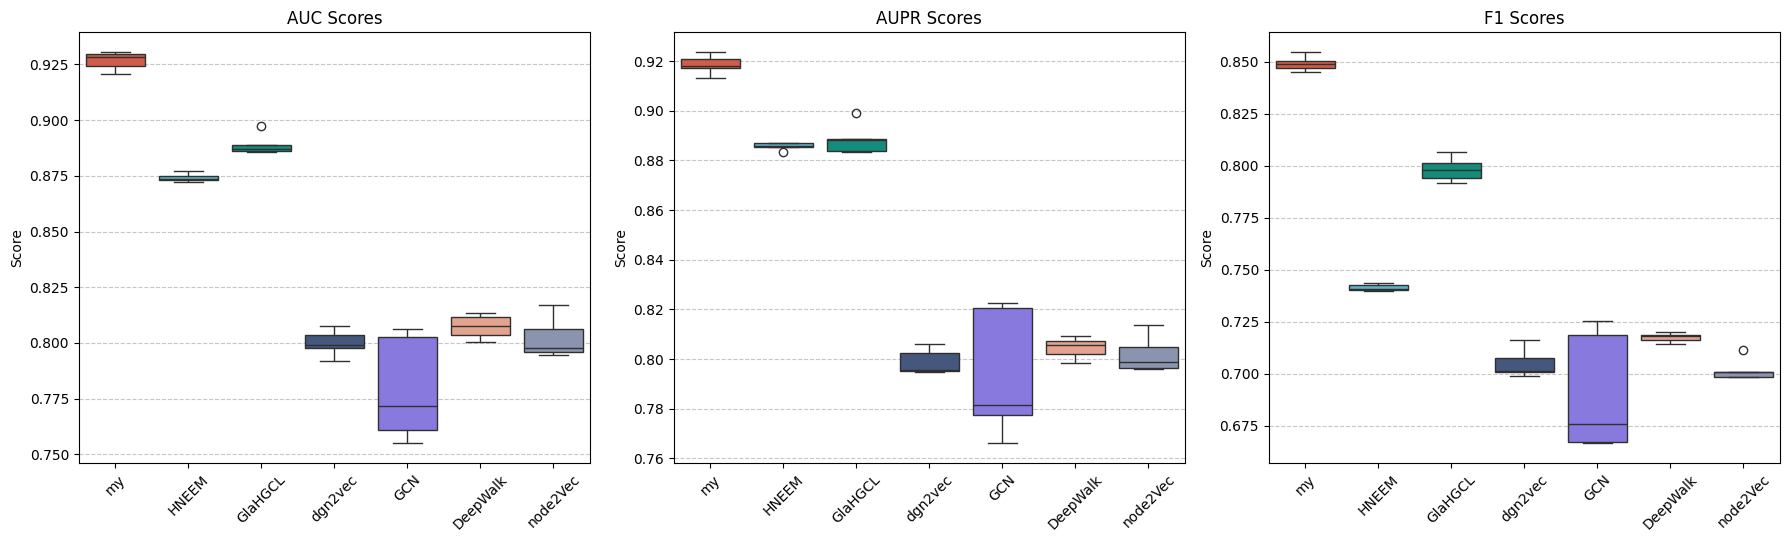

C:\Users\wsy\AppData\Local\Temp\ipykernel_10400\2322186857.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Value', data=metric_data, ax=ax, palette=colors)
C:\Users\wsy\AppData\Local\Temp\ipykernel_10400\2322186857.py:110: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.boxplot(x='Model', y='Value', data=metric_data, ax=ax, palette=colors)
C:\Users\wsy\AppData\Local\Temp\ipykernel_10400\2322186857.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Value', data=metric_data, ax=ax, palette=colors)
C:\Users\wsy\AppData\Local\Temp\ipykernel_10400\2322186857.py:110: UserWarning: The palette list has more v

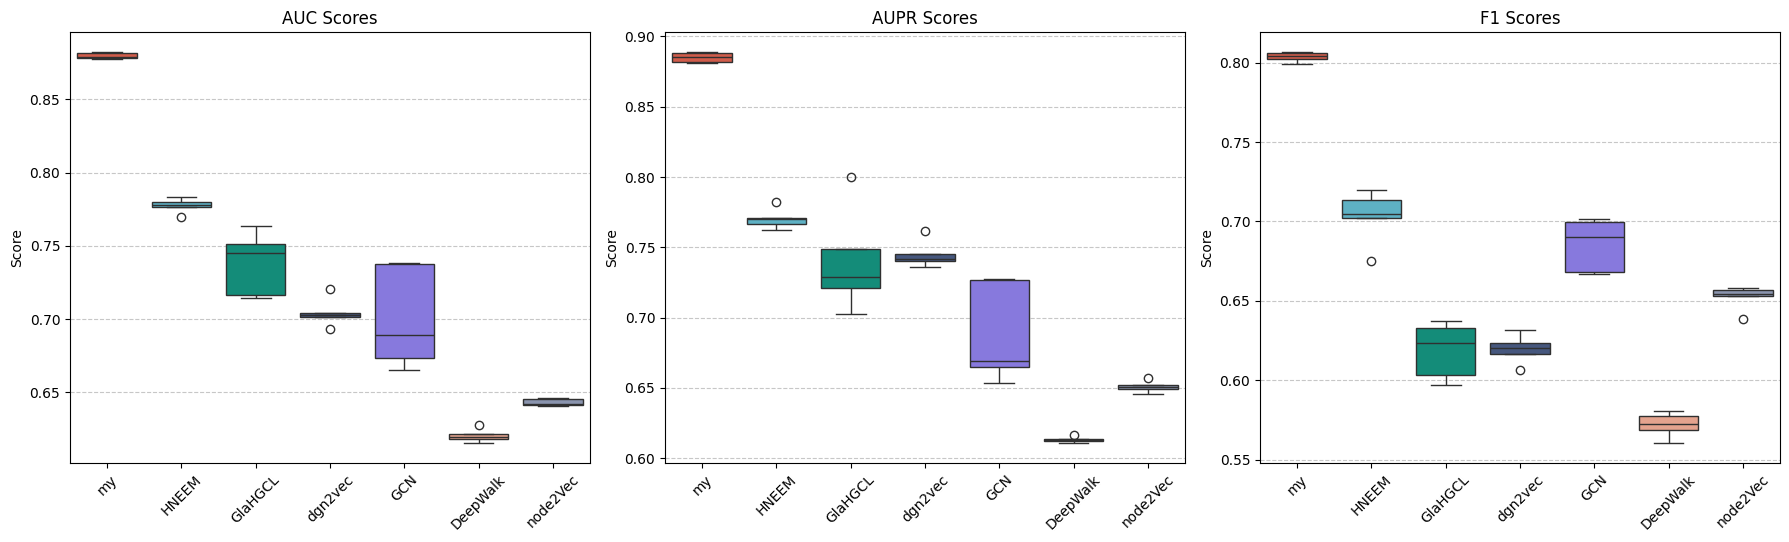

In [10]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = [
    #My full model
    ('my', 'dataset1', 'auc', 0.9242), ('my', 'dataset1', 'aupr', 0.9181), ('my', 'dataset1', 'f1', 0.8501),
    ('my', 'dataset1', 'auc', 0.9283), ('my', 'dataset1', 'aupr', 0.9210), ('my', 'dataset1', 'f1', 0.8491),
    ('my', 'dataset1', 'auc', 0.9306), ('my', 'dataset1', 'aupr', 0.9237), ('my', 'dataset1', 'f1', 0.8547),
    ('my', 'dataset1', 'auc', 0.9205), ('my', 'dataset1', 'aupr', 0.9130), ('my', 'dataset1', 'f1', 0.8450),
    ('my', 'dataset1', 'auc', 0.9297), ('my', 'dataset1', 'aupr', 0.9172), ('my', 'dataset1', 'f1', 0.8468),
    ('my', 'dataset2', 'auc', 0.8824), ('my', 'dataset2', 'aupr', 0.8890), ('my', 'dataset2', 'f1', 0.8044),
    ('my', 'dataset2', 'auc', 0.8817), ('my', 'dataset2', 'aupr', 0.8883), ('my', 'dataset2', 'f1', 0.8067),
    ('my', 'dataset2', 'auc', 0.8792), ('my', 'dataset2', 'aupr', 0.8857), ('my', 'dataset2', 'f1', 0.7993),
    ('my', 'dataset2', 'auc', 0.8773), ('my', 'dataset2', 'aupr', 0.8817), ('my', 'dataset2', 'f1', 0.8022),
    ('my', 'dataset2', 'auc', 0.8782), ('my', 'dataset2', 'aupr', 0.8809), ('my', 'dataset2', 'f1', 0.8061),
    
    # HNEEM
    ('HNEEM', 'dataset1', 'auc', 0.8720), ('HNEEM', 'dataset1', 'aupr', 0.8832), ('HNEEM', 'dataset1', 'f1', 0.7410),
    ('HNEEM', 'dataset1', 'auc', 0.8736), ('HNEEM', 'dataset1', 'aupr', 0.8859), ('HNEEM', 'dataset1', 'f1', 0.7436),
    ('HNEEM', 'dataset1', 'auc', 0.8748), ('HNEEM', 'dataset1', 'aupr', 0.8869), ('HNEEM', 'dataset1', 'f1', 0.7398),
    ('HNEEM', 'dataset1', 'auc', 0.8732), ('HNEEM', 'dataset1', 'aupr', 0.8856), ('HNEEM', 'dataset1', 'f1', 0.7401),
    ('HNEEM', 'dataset1', 'auc', 0.8771), ('HNEEM', 'dataset1', 'aupr', 0.8869), ('HNEEM', 'dataset1', 'f1', 0.7428),
    ('HNEEM', 'dataset2', 'auc', 0.7696), ('HNEEM', 'dataset2', 'aupr', 0.7626), ('HNEEM', 'dataset2', 'f1', 0.6750),
    ('HNEEM', 'dataset2', 'auc', 0.7768), ('HNEEM', 'dataset2', 'aupr', 0.7667), ('HNEEM', 'dataset2', 'f1', 0.7025),
    ('HNEEM', 'dataset2', 'auc', 0.7836), ('HNEEM', 'dataset2', 'aupr', 0.7821), ('HNEEM', 'dataset2', 'f1', 0.7134),
    ('HNEEM', 'dataset2', 'auc', 0.7780), ('HNEEM', 'dataset2', 'aupr', 0.7699), ('HNEEM', 'dataset2', 'f1', 0.7047),
    ('HNEEM', 'dataset2', 'auc', 0.7802), ('HNEEM', 'dataset2', 'aupr', 0.7705), ('HNEEM', 'dataset2', 'f1', 0.7199),
    
    # GlaHGCL
    ('GlaHGCL', 'dataset1', 'auc', 0.8974), ('GlaHGCL', 'dataset1', 'aupr', 0.8992), ('GlaHGCL', 'dataset1', 'f1', 0.8064),
    ('GlaHGCL', 'dataset1', 'auc', 0.8872), ('GlaHGCL', 'dataset1', 'aupr', 0.8884), ('GlaHGCL', 'dataset1', 'f1', 0.7942),
    ('GlaHGCL', 'dataset1', 'auc', 0.8855), ('GlaHGCL', 'dataset1', 'aupr', 0.8886), ('GlaHGCL', 'dataset1', 'f1', 0.7979),
    ('GlaHGCL', 'dataset1', 'auc', 0.8860), ('GlaHGCL', 'dataset1', 'aupr', 0.8833), ('GlaHGCL', 'dataset1', 'f1', 0.7917),
    ('GlaHGCL', 'dataset1', 'auc', 0.8886), ('GlaHGCL', 'dataset1', 'aupr', 0.8836), ('GlaHGCL', 'dataset1', 'f1', 0.8014),
    ('GlaHGCL', 'dataset2', 'auc', 0.7510), ('GlaHGCL', 'dataset2', 'aupr', 0.7287), ('GlaHGCL', 'dataset2', 'f1', 0.6032),
    ('GlaHGCL', 'dataset2', 'auc', 0.7142), ('GlaHGCL', 'dataset2', 'aupr', 0.7998), ('GlaHGCL', 'dataset2', 'f1', 0.6373),
    ('GlaHGCL', 'dataset2', 'auc', 0.7448), ('GlaHGCL', 'dataset2', 'aupr', 0.7207), ('GlaHGCL', 'dataset2', 'f1', 0.6235),
    ('GlaHGCL', 'dataset2', 'auc', 0.7637), ('GlaHGCL', 'dataset2', 'aupr', 0.7490), ('GlaHGCL', 'dataset2', 'f1', 0.6333),
    ('GlaHGCL', 'dataset2', 'auc', 0.7163), ('GlaHGCL', 'dataset2', 'aupr', 0.7022), ('GlaHGCL', 'dataset2', 'f1', 0.5971),    

    # dgn2vec
    ('dgn2vec', 'dataset1', 'auc', 0.7976), ('dgn2vec', 'dataset1', 'aupr', 0.7953), ('dgn2vec', 'dataset1', 'f1', 0.7012),
    ('dgn2vec', 'dataset1', 'auc', 0.8035), ('dgn2vec', 'dataset1', 'aupr', 0.8026), ('dgn2vec', 'dataset1', 'f1', 0.7076),
    ('dgn2vec', 'dataset1', 'auc', 0.7990), ('dgn2vec', 'dataset1', 'aupr', 0.7957), ('dgn2vec', 'dataset1', 'f1', 0.6992),
    ('dgn2vec', 'dataset1', 'auc', 0.8075), ('dgn2vec', 'dataset1', 'aupr', 0.8059), ('dgn2vec', 'dataset1', 'f1', 0.7165),
    ('dgn2vec', 'dataset1', 'auc', 0.7917), ('dgn2vec', 'dataset1', 'aupr', 0.7948), ('dgn2vec', 'dataset1', 'f1', 0.7011),
    ('dgn2vec', 'dataset2', 'auc', 0.6936), ('dgn2vec', 'dataset2', 'aupr', 0.7363), ('dgn2vec', 'dataset2', 'f1', 0.6065),
    ('dgn2vec', 'dataset2', 'auc', 0.7203), ('dgn2vec', 'dataset2', 'aupr', 0.7614), ('dgn2vec', 'dataset2', 'f1', 0.6315),
    ('dgn2vec', 'dataset2', 'auc', 0.7030), ('dgn2vec', 'dataset2', 'aupr', 0.7403), ('dgn2vec', 'dataset2', 'f1', 0.6233),
    ('dgn2vec', 'dataset2', 'auc', 0.7012), ('dgn2vec', 'dataset2', 'aupr', 0.7420), ('dgn2vec', 'dataset2', 'f1', 0.6204),
    ('dgn2vec', 'dataset2', 'auc', 0.7040), ('dgn2vec', 'dataset2', 'aupr', 0.7451), ('dgn2vec', 'dataset2', 'f1', 0.6169),

    # GCN
    ('GCN', 'dataset1', 'auc', 0.7550), ('GCN', 'dataset1', 'aupr', 0.7661), ('GCN', 'dataset1', 'f1', 0.6667),
    ('GCN', 'dataset1', 'auc', 0.7610), ('GCN', 'dataset1', 'aupr', 0.7773), ('GCN', 'dataset1', 'f1', 0.6760),
    ('GCN', 'dataset1', 'auc', 0.8062), ('GCN', 'dataset1', 'aupr', 0.8225), ('GCN', 'dataset1', 'f1', 0.7189),
    ('GCN', 'dataset1', 'auc', 0.7715), ('GCN', 'dataset1', 'aupr', 0.7814), ('GCN', 'dataset1', 'f1', 0.6672),
    ('GCN', 'dataset1', 'auc', 0.8027), ('GCN', 'dataset1', 'aupr', 0.8206), ('GCN', 'dataset1', 'f1', 0.7254),
    ('GCN', 'dataset2', 'auc', 0.6650), ('GCN', 'dataset2', 'aupr', 0.6536), ('GCN', 'dataset2', 'f1', 0.6667),
    ('GCN', 'dataset2', 'auc', 0.6737), ('GCN', 'dataset2', 'aupr', 0.6645), ('GCN', 'dataset2', 'f1', 0.6900),
    ('GCN', 'dataset2', 'auc', 0.7383), ('GCN', 'dataset2', 'aupr', 0.7265), ('GCN', 'dataset2', 'f1', 0.6996),
    ('GCN', 'dataset2', 'auc', 0.6889), ('GCN', 'dataset2', 'aupr', 0.6690), ('GCN', 'dataset2', 'f1', 0.6680),
    ('GCN', 'dataset2', 'auc', 0.7378), ('GCN', 'dataset2', 'aupr', 0.7274), ('GCN', 'dataset2', 'f1', 0.7015),

    # DeepWalk
    ('DeepWalk', 'dataset1', 'auc', 0.8133), ('DeepWalk', 'dataset1', 'aupr', 0.8093), ('DeepWalk', 'dataset1', 'f1', 0.7184),
    ('DeepWalk', 'dataset1', 'auc', 0.8037), ('DeepWalk', 'dataset1', 'aupr', 0.8019), ('DeepWalk', 'dataset1', 'f1', 0.7199),
    ('DeepWalk', 'dataset1', 'auc', 0.8078), ('DeepWalk', 'dataset1', 'aupr', 0.8055), ('DeepWalk', 'dataset1', 'f1', 0.7163),
    ('DeepWalk', 'dataset1', 'auc', 0.8006), ('DeepWalk', 'dataset1', 'aupr', 0.7986), ('DeepWalk', 'dataset1', 'f1', 0.7145),
    ('DeepWalk', 'dataset1', 'auc', 0.8115), ('DeepWalk', 'dataset1', 'aupr', 0.8071), ('DeepWalk', 'dataset1', 'f1', 0.7186),
    ('DeepWalk', 'dataset2', 'auc', 0.6276), ('DeepWalk', 'dataset2', 'aupr', 0.6163), ('DeepWalk', 'dataset2', 'f1', 0.5806),
    ('DeepWalk', 'dataset2', 'auc', 0.6183), ('DeepWalk', 'dataset2', 'aupr', 0.6106), ('DeepWalk', 'dataset2', 'f1', 0.5688),
    ('DeepWalk', 'dataset2', 'auc', 0.6196), ('DeepWalk', 'dataset2', 'aupr', 0.6131), ('DeepWalk', 'dataset2', 'f1', 0.5778),
    ('DeepWalk', 'dataset2', 'auc', 0.6153), ('DeepWalk', 'dataset2', 'aupr', 0.6137), ('DeepWalk', 'dataset2', 'f1', 0.5605),
    ('DeepWalk', 'dataset2', 'auc', 0.6217), ('DeepWalk', 'dataset2', 'aupr', 0.6122), ('DeepWalk', 'dataset2', 'f1', 0.5727),

    # node2Vec
    ('node2Vec', 'dataset1', 'auc', 0.8172), ('node2Vec', 'dataset1', 'aupr', 0.8138), ('node2Vec', 'dataset1', 'f1', 0.7114),
    ('node2Vec', 'dataset1', 'auc', 0.7948), ('node2Vec', 'dataset1', 'aupr', 0.7958), ('node2Vec', 'dataset1', 'f1', 0.6986),
    ('node2Vec', 'dataset1', 'auc', 0.7977), ('node2Vec', 'dataset1', 'aupr', 0.7987), ('node2Vec', 'dataset1', 'f1', 0.7007),
    ('node2Vec', 'dataset1', 'auc', 0.7958), ('node2Vec', 'dataset1', 'aupr', 0.7964), ('node2Vec', 'dataset1', 'f1', 0.6985),
    ('node2Vec', 'dataset1', 'auc', 0.8063), ('node2Vec', 'dataset1', 'aupr', 0.8048), ('node2Vec', 'dataset1', 'f1', 0.7011),
    ('node2Vec', 'dataset2', 'auc', 0.6460), ('node2Vec', 'dataset2', 'aupr', 0.6491), ('node2Vec', 'dataset2', 'f1', 0.6387),
    ('node2Vec', 'dataset2', 'auc', 0.6406), ('node2Vec', 'dataset2', 'aupr', 0.6518), ('node2Vec', 'dataset2', 'f1', 0.6582),
    ('node2Vec', 'dataset2', 'auc', 0.6412), ('node2Vec', 'dataset2', 'aupr', 0.6458), ('node2Vec', 'dataset2', 'f1', 0.6529),
    ('node2Vec', 'dataset2', 'auc', 0.6423), ('node2Vec', 'dataset2', 'aupr', 0.6570), ('node2Vec', 'dataset2', 'f1', 0.6566),
    ('node2Vec', 'dataset2', 'auc', 0.6455), ('node2Vec', 'dataset2', 'aupr', 0.6507), ('node2Vec', 'dataset2', 'f1', 0.6544),
]

df = pd.DataFrame(data, columns=['Model', 'Dataset', 'Metric', 'Value'])

def plot_dataset_metrics(df, dataset_name):
    df_dataset = df[df['Dataset'] == dataset_name]

    metrics = df_dataset['Metric'].unique()

    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 6), sharey=False)
    # fig.suptitle(f'Model Performance Comparison on {dataset_name}', fontsize=16)
    
    colors = [
        '#E64B35B2', '#4DBBD5B2', '#00A087B2', '#3C5488B2', '#7b68ee', 
        "#F39B7FB2", '#8491B4B2', '#ff8c00', '#7b68ee', '#f9ccd1', 
    ]

    for i, metric in enumerate(metrics):
        ax = axes[i]
        metric_data = df_dataset[df_dataset['Metric'] == metric]

        sns.boxplot(x='Model', y='Value', data=metric_data, ax=ax, palette=colors)
        
        ax.set_title(f'{metric.upper()} Scores', fontsize=12)
        ax.set_xlabel(None)
        ax.set_ylabel('Score', fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("figure/" + dataset_name + "_evluation", dpi=300)
    plt.show()

plot_dataset_metrics(df, 'dataset1')
plot_dataset_metrics(df, 'dataset2')

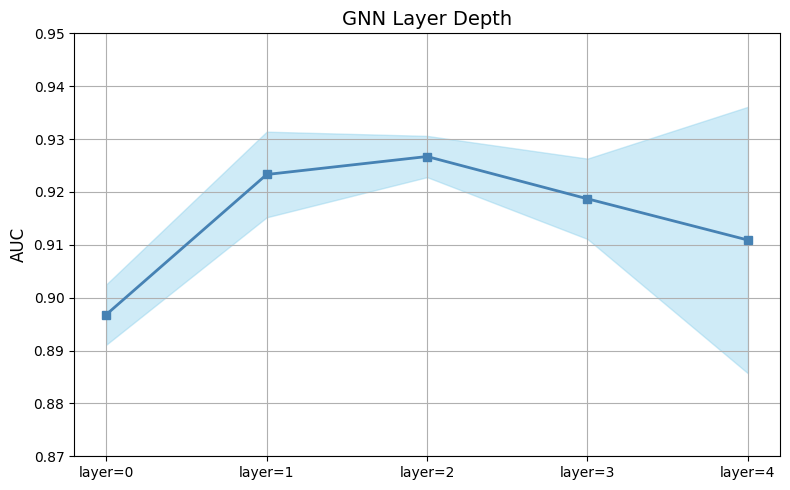

In [11]:
import matplotlib.pyplot as plt
import numpy as np

GNN_layers = ['layer=0', 'layer=1', 'layer=2', 'layer=3', 'layer=4']
mean_AUC = np.array([0.8968, 0.9233, 0.9267, 0.9187, 0.9109])
std_AUC = np.array([0.0057, 0.0081, 0.0039, 0.0076, 0.0252])

upper = mean_AUC + std_AUC
lower = mean_AUC - std_AUC

plt.figure(figsize=(8, 5))
plt.plot(GNN_layers, mean_AUC, marker='s', color='steelblue', linewidth=2)
plt.fill_between(GNN_layers, lower, upper, color='skyblue', alpha=0.4)

plt.title('GNN Layer Depth', fontsize=14)
plt.ylabel('AUC', fontsize=12)
plt.ylim(0.87, 0.95)
plt.grid(True)
plt.tight_layout()
plt.savefig("figure/gnn layer depth", dpi=300)
plt.show()


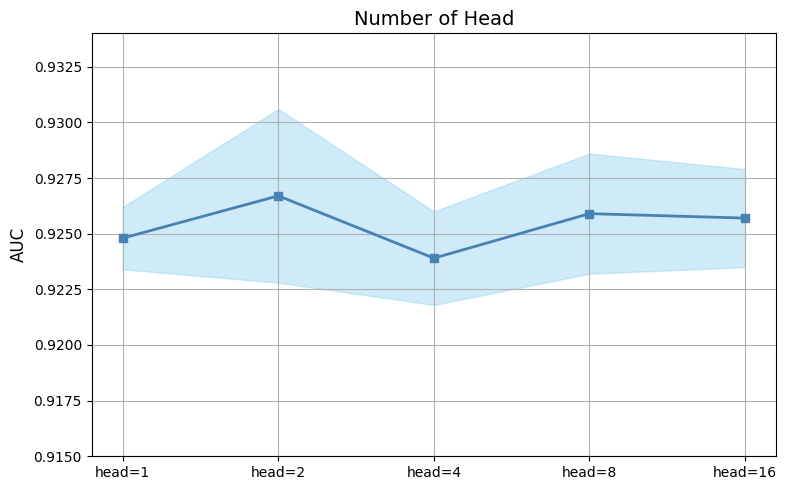

In [12]:
import matplotlib.pyplot as plt
import numpy as np

GNN_layers = ['head=1', 'head=2', 'head=4', 'head=8', 'head=16']
mean_AUC = np.array([0.9248, 0.9267, 0.9239, 0.9259, 0.9257])
std_AUC = np.array([0.0014, 0.0039, 0.0021, 0.0027, 0.0022])

upper = mean_AUC + std_AUC
lower = mean_AUC - std_AUC

plt.figure(figsize=(8, 5))
plt.plot(GNN_layers, mean_AUC, marker='s', color='steelblue', linewidth=2)
plt.fill_between(GNN_layers, lower, upper, color='skyblue', alpha=0.4)

plt.title('Number of Head', fontsize=14)
plt.ylabel('AUC', fontsize=12)
plt.ylim(0.915, 0.934)
plt.grid(True)
plt.tight_layout()
plt.savefig("figure/number of head", dpi=300)
plt.show()

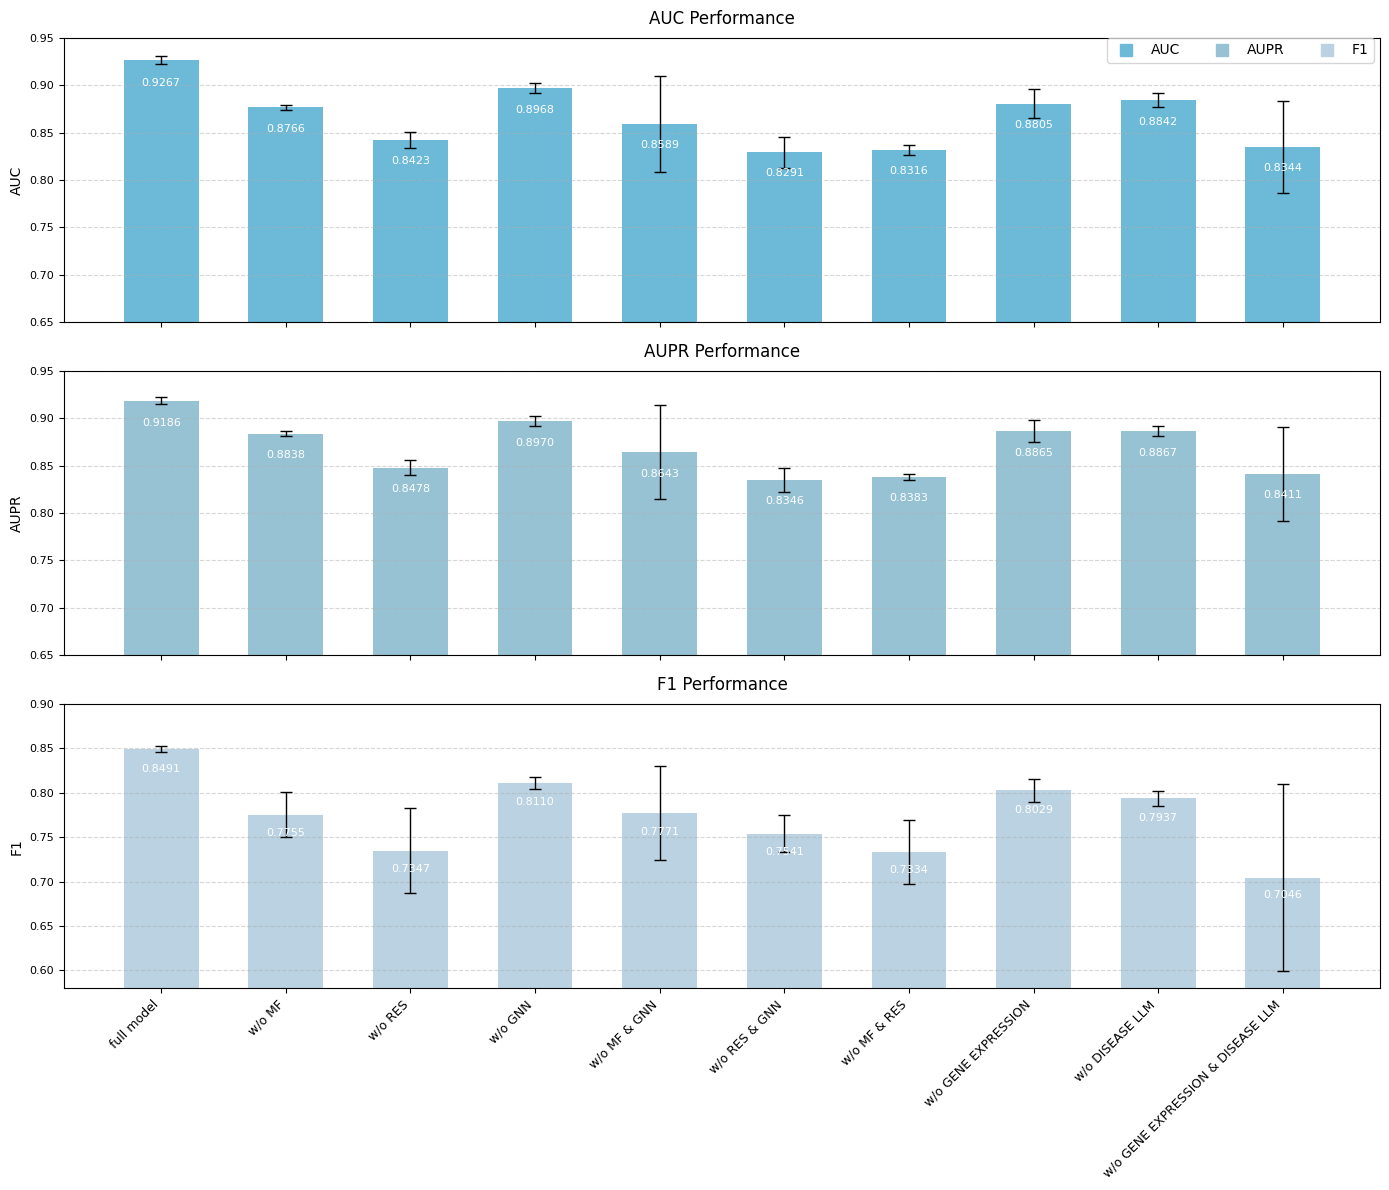

In [9]:
# 消融实验
import matplotlib.lines as mlines
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

models = ['full model', 'w/o MF', 'w/o RES', 'w/o GNN', 'w/o MF & GNN', 'w/o RES & GNN', 'w/o MF & RES', 'w/o GENE EXPRESSION', 'w/o DISEASE LLM', 'w/o GENE EXPRESSION & DISEASE LLM']
metrics = ['auc', 'aupr', 'f1']

data1 = {
    'full model':
        {
            'auc':[0.9267, 0.0038],
            'aupr':[0.9186, 0.0036],
            'f1':[0.8491, 0.0033]
        },
    'w/o MF':
        {
            'auc':[0.8766, 0.0030],
            'aupr':[0.8838, 0.0027],
            'f1':[0.7755, 0.0257]
        },
    'w/o RES':
        {
            'auc':[0.8423, 0.0087],
            'aupr':[0.8478, 0.0077],
            'f1':[0.7347, 0.0479]
        },
    'w/o GNN':
        {
            'auc':[0.8968, 0.0051],
            'aupr':[0.8970, 0.0050],
            'f1':[0.8110, 0.0071]
        },
    'w/o MF & GNN':
        {
            'auc':[0.8589, 0.0509],
            'aupr':[0.8643, 0.0499],
            'f1':[0.7771, 0.0528]
        },
    'w/o RES & GNN':
        {
            'auc':[0.8291, 0.0163],
            'aupr':[0.8346, 0.0126],
            'f1':[0.7541, 0.0206]
        },
    'w/o MF & RES':
        {
            'auc':[0.8316, 0.0051],
            'aupr':[0.8383, 0.0034],
            'f1':[0.7334, 0.0360]
        },
    'w/o GENE EXPRESSION':
        {
            'auc':[0.8805, 0.0153],
            'aupr':[0.8865, 0.0120],
            'f1':[0.8029, 0.0130]
        },
    'w/o DISEASE LLM':
        {
            'auc':[0.8842, 0.0074],
            'aupr':[0.8867, 0.0051],
            'f1':[0.7937, 0.0089]
        },
    'w/o GENE EXPRESSION & DISEASE LLM':
        {
            'auc':[0.8344, 0.0486],
            'aupr':[0.8411, 0.0493],
            'f1':[0.7046, 0.1048]
        },
}

metrics = ['auc', 'aupr', 'f1']
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

colors = ['#6CBAD8', '#96C2D4', '#BAD2E1']
x = np.arange(len(models))
width = 0.6

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx]

    metric_data = [data1[model][metric] for model in models]
    means = [x[0] for x in metric_data]
    stds = [x[1] for x in metric_data]

    bars = ax.bar(x, means, width, 
                 yerr=stds, 
                 color=color,
                 capsize=4,
                 error_kw={'elinewidth': 1})

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height*0.98,
                f'{height:.4f}',
                ha='center', va='top',
                color='white',
                fontsize=8)

    ax.set_ylabel(metric.upper(), fontsize=10)
    ax.set_ylim(0.65, 0.95) if metric != 'f1' else ax.set_ylim(0.58, 0.9)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(axis='y', labelsize=8)
    
    ax.set_title(f'{metric.upper()} Performance', fontsize=12, pad=10)

plt.xticks(x, models, rotation=45, ha='right', fontsize=9)
# plt.xlabel('Ablation Configurations', fontsize=10, labelpad=15)
plt.tight_layout()

legend_labels = [mlines.Line2D([], [], color=color, marker='s', 
                              linestyle='', markersize=8, 
                              label=metric.upper()) 
                for metric, color in zip(metrics, colors)]
fig.legend(handles=legend_labels, 
          loc='upper right', 
          bbox_to_anchor=(0.99, 0.97),
          ncol=3)
plt.savefig("figure/abation.png", dpi=300)
plt.show()

In [ ]:
import pandas as pd

train_map_filepath = "Dataset/Data/trainnode_index_map.xlsx"
train_node_dict = pd.read_excel(train_map_filepath)
train_disease_map = train_node_dict['disease'].dropna().astype(int)

# find the target disease and it's top 10 gene
target_disease_index = 14
disease_name = pd.read_csv('Raw_Data/disease_name.csv').iloc[:, 1].tolist()
target_disease = disease_name[train_disease_map.iloc[target_disease_index]]
print("target disease:", target_disease)

predict_edges = np.column_stack((np.full(6465, target_disease_index), np.arange(0, 6464)))


target disease: allergic asthma


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from collections import OrderedDict
from sklearn.metrics.pairwise import cosine_similarity

def get_category(TreeNum):
    if pd.isna(TreeNum):
        return 'Uncategorized'
    
    top_layer_categorty = [cls.strip().split('.')[0] for cls in TreeNum.split(',')] #get top layer of mesh tree of the disease
    top_layer_categorty = list(OrderedDict.fromkeys(top_layer_categorty))

    if len(top_layer_categorty) == 1:
        return top_layer_categorty[0]
    elif len(top_layer_categorty) > 1:
        # return 'Multi-category'
        return '&'.join(top_layer_categorty)
    else:
        return 'Uncategorized'

uncategoried_list = [14, 85, 117, 133, 134, 207]
train_map_filepath = "Dataset/Data/trainnode_index_map.xlsx"
train_node_dict = pd.read_excel(train_map_filepath)
train_disease_map = train_node_dict['disease'].dropna().astype(int)

# find the target disease
for target_disease_index in  uncategoried_list:
    disease_name = pd.read_csv('Raw_Data/disease_name.csv').iloc[:, 1].tolist()
    target_disease = disease_name[train_disease_map.iloc[target_disease_index]]
    print("target disease:", target_disease)
    
embeddings = np.load('results/My/train_disease_embeddings.npy')
labels = pd.read_csv('Raw_Data/MeshId_TreeNum.csv', sep='\t').iloc[train_disease_map.tolist()]['TreeNum'].apply(get_category).tolist()

all_embeddings = embeddings
all_labels = labels

is_uncategorized = np.array([1 if l == 'Uncategorized' else 0 for l in all_labels])

labeled_idx = np.where(is_uncategorized == 0)[0]
unlabeled_idx = np.where(is_uncategorized == 1)[0]

X_train = all_embeddings[labeled_idx]
y_train = [all_labels[i] for i in labeled_idx]
X_test = all_embeddings[unlabeled_idx]

knn = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Predicted categories for uncategorized diseases:")
for idx, pred in zip(uncategoried_list, y_pred):
    print(f"Disease index {idx}: {pred}")

target disease: allergic asthma
target disease: frontotemporal dementia
target disease: retinal vascular disease
target disease: thyroid medullary carcinoma
target disease: generalized epilepsy with febrile seizures plus
target disease: skin melanoma
Predicted categories for uncategorized diseases:
Disease index 14: C05
Disease index 85: F03
Disease index 117: C11
Disease index 133: C04
Disease index 134: C10&C16
Disease index 207: C04
